In [9]:
import os
os.environ["OMP_NUM_THREADS"] = "8"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import petitRADTRANS as prt
from petitRADTRANS.retrieval.models import madhushudhan_seager_transmission_modified, madhushudhan_seager_transmission
from models import madhu_seager_two_layers
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig
from petitRADTRANS.retrieval.models import Planet
from petitRADTRANS.retrieval.utils import log_prior
from matplotlib.patches import Rectangle
from petitRADTRANS.plotlib import plot_radtrans_opacities

from petitRADTRANS.retrieval.models import (
    isothermal_transmission,
    guillot_transmission,
    guillot_patchy_transmission,
    madhu_seager_patchy_transmission
)
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.plotlib.style import set_petitradtrans_plot_style

set_petitradtrans_plot_style()

Using pRT Plotting style!


In [2]:
planet = Planet.get("K2-18 b")
root_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))

retrieval_config = RetrievalConfig(retrieval_name="K2-18b_seager_grey_clouds_standard",
                                run_mode="retrieve",
                                amr=False,
                                scattering_in_emission=True,
                                pressures=np.logspace(-6, 2, 120),
                                  )

retrieval_config.add_data(
    "K2-18b_NIRISS",
    os.path.join(root_path, "spectra/K2-18b_NIRISS.txt"),
    data_resolution=700,
    model_resolution=1500,
    model_generating_function=madhushudhan_seager_transmission_modified,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_data(
    "K2-18b_NIRSPEC",
    os.path.join(root_path, "spectra/K2-18b_NIRSPEC.txt"),
    data_resolution=2700,
    model_resolution=1500,
    model_generating_function=madhushudhan_seager_transmission_modified,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_parameter('D_pl', False, value=124.265*cst.light_year)
retrieval_config.add_parameter('stellar_radius', False, value=planet.star_radius)
retrieval_config.add_parameter('planet_radius', False, value = 0.211*cst.r_jup)
retrieval_config.add_parameter('mass', False, value = 0.02807*cst.m_jup)

retrieval_config.add_parameter('P2', True, transform_prior_cube_coordinate = lambda x: log_prior(x, -6, 0))
retrieval_config.add_parameter('P1', True, transform_prior_cube_coordinate = lambda x: log_prior(x, -6, 0))
retrieval_config.add_parameter('log_P_set', True, transform_prior_cube_coordinate = lambda x: -6+6*x)
retrieval_config.add_parameter('T_set', True, transform_prior_cube_coordinate = lambda x: 100+250*x)
retrieval_config.add_parameter('alpha_0', True, transform_prior_cube_coordinate = lambda x:  -3+6*x)
retrieval_config.add_parameter('alpha_1', True, transform_prior_cube_coordinate = lambda x: -3+6*x)
retrieval_config.add_parameter('log_Pcloud', True, transform_prior_cube_coordinate = lambda x: -6+7*x)
retrieval_config.add_parameter('patchiness', True, transform_prior_cube_coordinate = lambda x: 1*x)

retrieval_config.set_rayleigh_species(['H2', 'He'])
retrieval_config.set_continuum_opacities(["H2-H2","H2-He"])
retrieval_config.set_line_species(['CH4', 'CO2', 'H2O', 'NH3'], eq=False, abund_lim = (-8.0,-0.1))

retrieval_config.parameters['P2'].plot_in_corner = True
retrieval_config.parameters['P2'].corner_ranges = (-6,0)
retrieval_config.parameters['P2'].corner_transform = lambda x: np.log10(x)
retrieval_config.parameters['P1'].plot_in_corner = True
retrieval_config.parameters['P1'].corner_ranges = (-6,0)
retrieval_config.parameters['P1'].corner_transform = lambda x: np.log10(x)
retrieval_config.parameters['log_P_set'].plot_in_corner = True
retrieval_config.parameters['log_P_set'].corner_ranges = (-6,0)
retrieval_config.parameters['T_set'].plot_in_corner = True
retrieval_config.parameters['T_set'].corner_ranges = (100,500)
retrieval_config.parameters['alpha_0'].plot_in_corner = True
retrieval_config.parameters['alpha_0'].corner_ranges = (-3,0)
retrieval_config.parameters['alpha_1'].plot_in_corner = True
retrieval_config.parameters['alpha_1'].corner_ranges = (-2,2)
retrieval_config.parameters['patchiness'].plot_in_corner = True
retrieval_config.parameters['patchiness'].corner_ranges = (0,1)
retrieval_config.parameters['log_Pcloud'].plot_in_corner = True
retrieval_config.parameters['log_Pcloud'].corner_ranges = (-6,1)

for spec in retrieval_config.line_species:
    retrieval_config.parameters[spec].plot_in_corner = True
    retrieval_config.parameters[spec].corner_ranges = (-8.2,0.2)

retrieval_config.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
retrieval_config.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
retrieval_config.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
retrieval_config.plot_kwargs["xscale"] = 'linear'
retrieval_config.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
retrieval_config.plot_kwargs["nsample"] = 100

retrieval_config.plot_kwargs["take_PTs_from"] = "K2-18b_NIRISS"
retrieval_config.plot_kwargs["temp_limits"] = [100, 800]
retrieval_config.plot_kwargs["press_limits"] = [1e-6, 1e2]

output_directory = os.path.join(root_path, "outputs")
retrieval = Retrieval(retrieval_config,
                      output_directory=output_directory,
                      use_mpi = False,        # Run locally, don't need to use MPI for massive parallelisation
                      evaluate_sample_spectra=False,      # Output the spectrum from nsample random samples.
                      use_prt_plot_style=True,
                      ultranest=False)        # Let's use pyMultiNestopacities = plot_radtrans_opacities(

retrieval.run(n_live_points=200,         # PMN number of live points. 400 is good for small retrievals, 4000 for large
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=True,
              error_checking=False) 

Setting up Radtrans object for data 'K2-18b_NIRISS'...
Loading Radtrans opacities...
 Loading line opacities of species 'CH4.R1500' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2.R1500' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O.R1500' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3.R1500' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRA

/home/juan/retrievals/petit/lib/python3.10/site-packages/petitRADTRANS/radtrans.py:2612: RuntimeWarning: overflow encountered in exp
  transparencies = np.exp(transparencies, out=transparencies)
/home/juan/retrievals/petit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/juan/retrievals/petit/lib/python3.10/site-packages/petitRADTRANS/radtrans.py:2640: RuntimeWarning: overflow encountered in multiply
  transparencies *= radius_hydrostatic_equilibrium
/home/juan/retrievals/petit/lib/python3.10/site-packages/petitRADTRANS/radtrans.py:2647: RuntimeWarning: invalid value encountered in sqrt
  transit_radii = np.sqrt(transit_radii + radius_hydrostatic_equilibrium[-1] ** 2.)
/home/juan/retrievals/petit/lib/python3.10/site-packages/petitRADTRANS/radtrans.py:2643: RuntimeWarning: overflow encountered in multiply
  transparencies *= annulus_radius_increments
/home/juan/

Acceptance Rate:                        0.043417
Replacements:                               3000
Total Samples:                             69097
Nested Sampling ln(Z):              28818.532185
Importance Nested Sampling ln(Z):   28814.614284 +/-  0.341301


/home/juan/retrievals/petit/lib/python3.10/site-packages/petitRADTRANS/radtrans.py:2643: RuntimeWarning: invalid value encountered in multiply
  transparencies *= annulus_radius_increments
/home/juan/retrievals/petit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Acceptance Rate:                        0.042718
Replacements:                               3050
Total Samples:                             71398
Nested Sampling ln(Z):              28818.579710
Importance Nested Sampling ln(Z):   28814.645718 +/-  0.330747
Acceptance Rate:                        0.042452
Replacements:                               3100
Total Samples:                             73023
Nested Sampling ln(Z):              28818.620359
Importance Nested Sampling ln(Z):   28814.667081 +/-  0.323760
Acceptance Rate:                        0.041929
Replacements:                               3150
Total Samples:                             75127
Nested Sampling ln(Z):              28818.656870
Importance Nested Sampling ln(Z):   28814.685792 +/-  0.317758
Acceptance Rate:                        0.041575
Replacements:                               3200
Total Samples:                             76969
Nested Sampling ln(Z):              28818.690206
Importance Nested Sampling 

Not in evaluate mode. Changing run mode to evaluate.

Plotting Best-fit spectrum
Best fit likelihood = 28833.89
P2 0.016820440572539036
P1 4.538144491538581e-06
log_P_set -4.27805456411447
T_set 302.5052031179479
alpha_0 -1.1240302137489662
alpha_1 0.44662568810168857
log_Pcloud -5.918550687501246
patchiness 0.6676921454931313
CH4 -1.2216246763919694
CO2 -0.9454016344722076
H2O -5.417684689728892
NH3 -6.132784098789042
Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000

/home/juan/retrievals/petit/lib/python3.10/site-packages/petitRADTRANS/retrieval/retrieval.py:4413: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


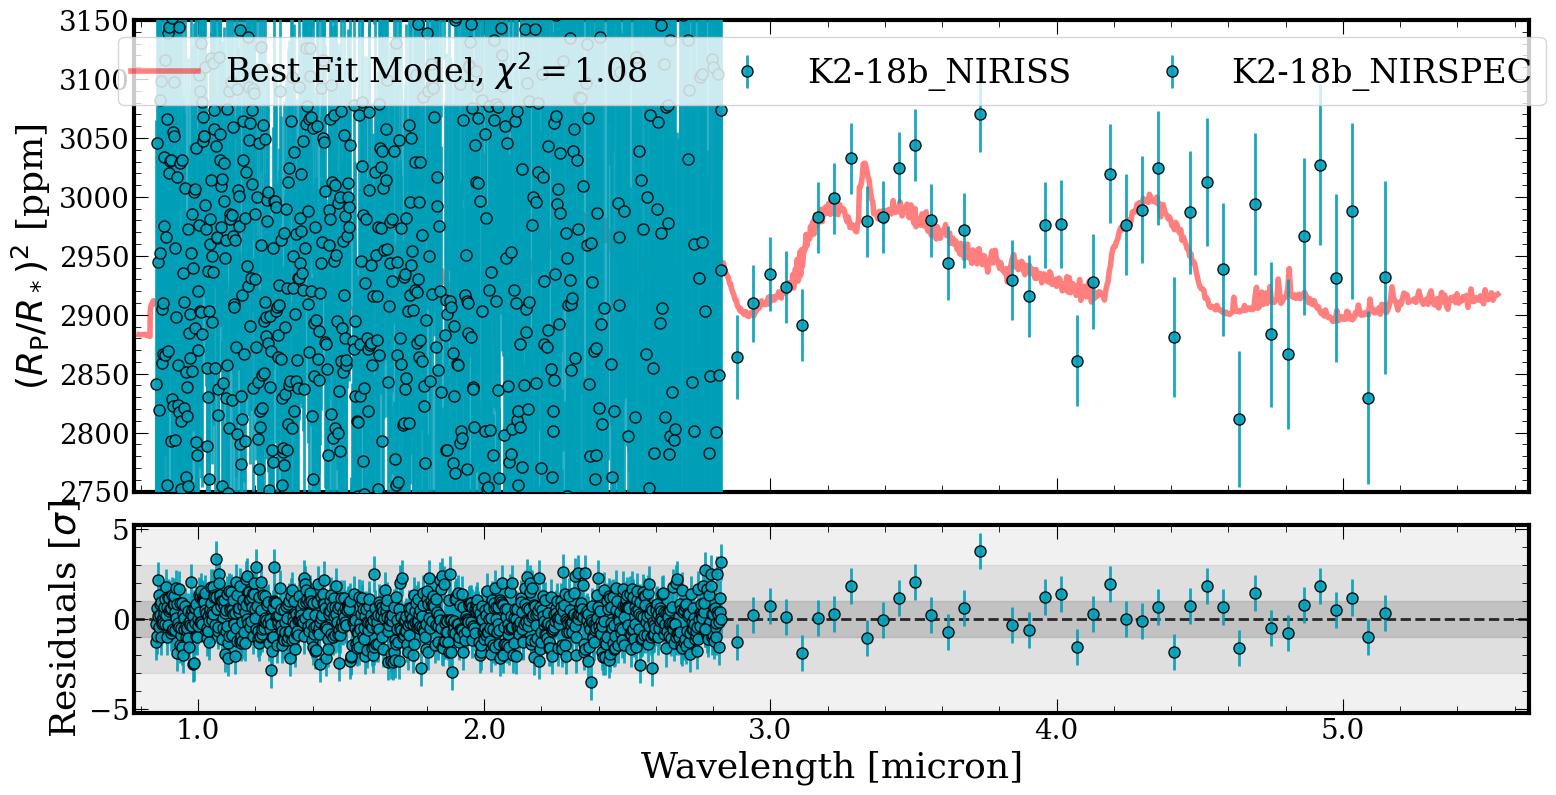

In [3]:
sample_dict, parameter_dict = retrieval.get_samples(output_directory=output_directory)
samples_use = sample_dict[retrieval.configuration.retrieval_name]
parameters_read = parameter_dict[retrieval.configuration.retrieval_name]


fig,ax,ax_r = retrieval.plot_spectra(samples_use, parameters_read, refresh = True, mode = 'bestfit')
ax.set_ylim(2750, 3150)
plt.show()


Plotting PT profiles


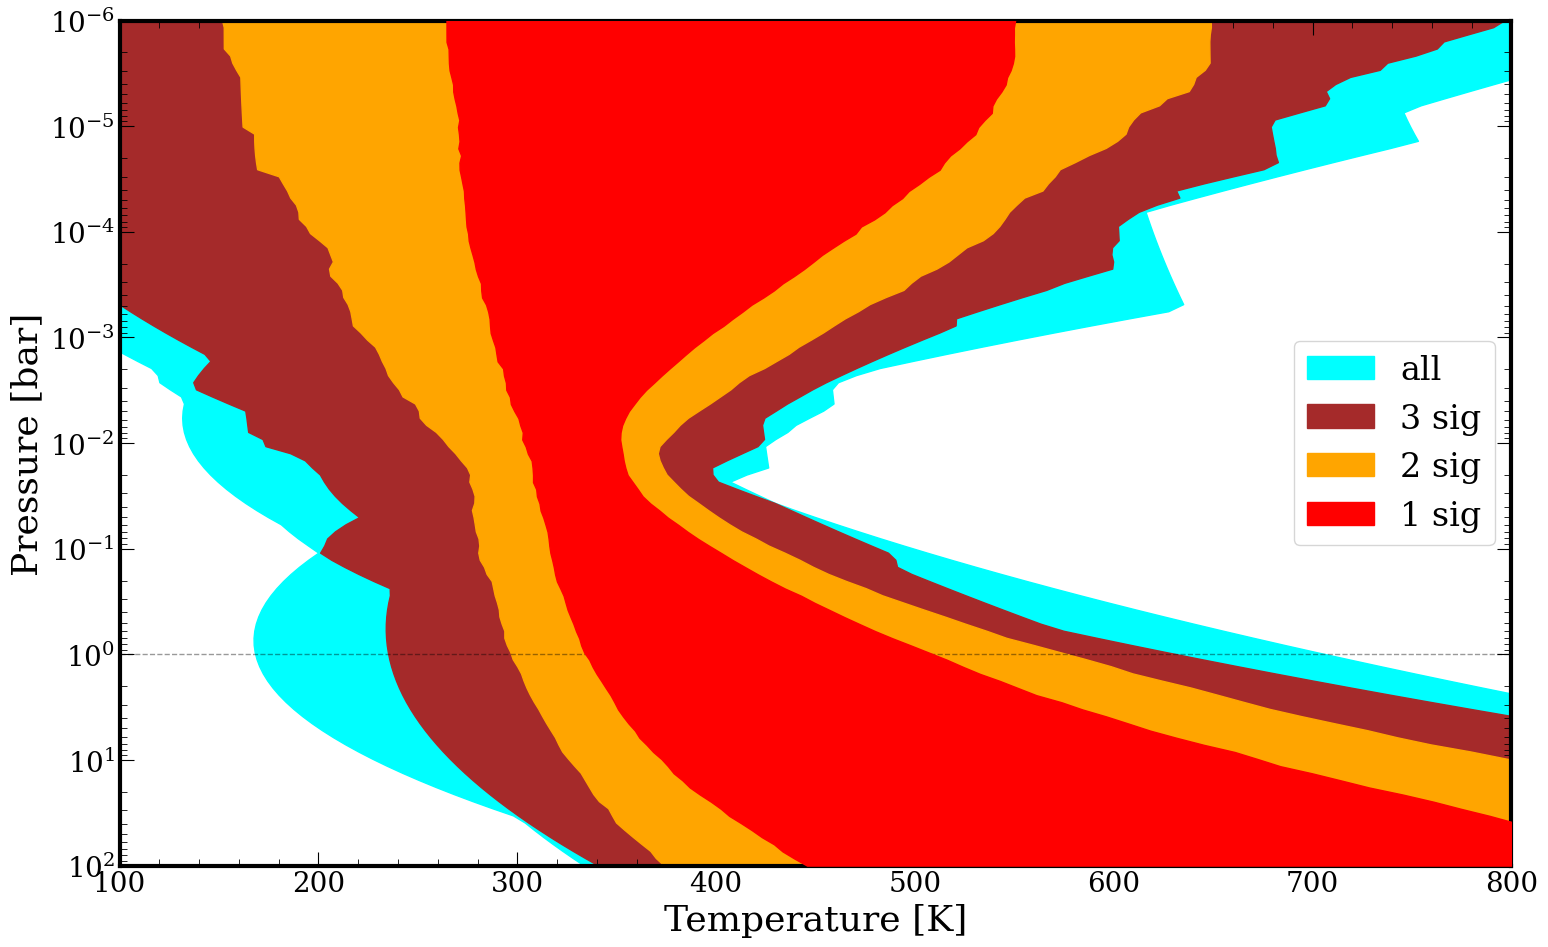

In [4]:
fig, ax = retrieval.plot_pt(sample_dict,parameters_read, contribution=False)
ax.axhline(y=0.986923, linestyle="--", color="k", linewidth=1, alpha=0.4)
ax.invert_yaxis()
plt.show()


Making corner plot


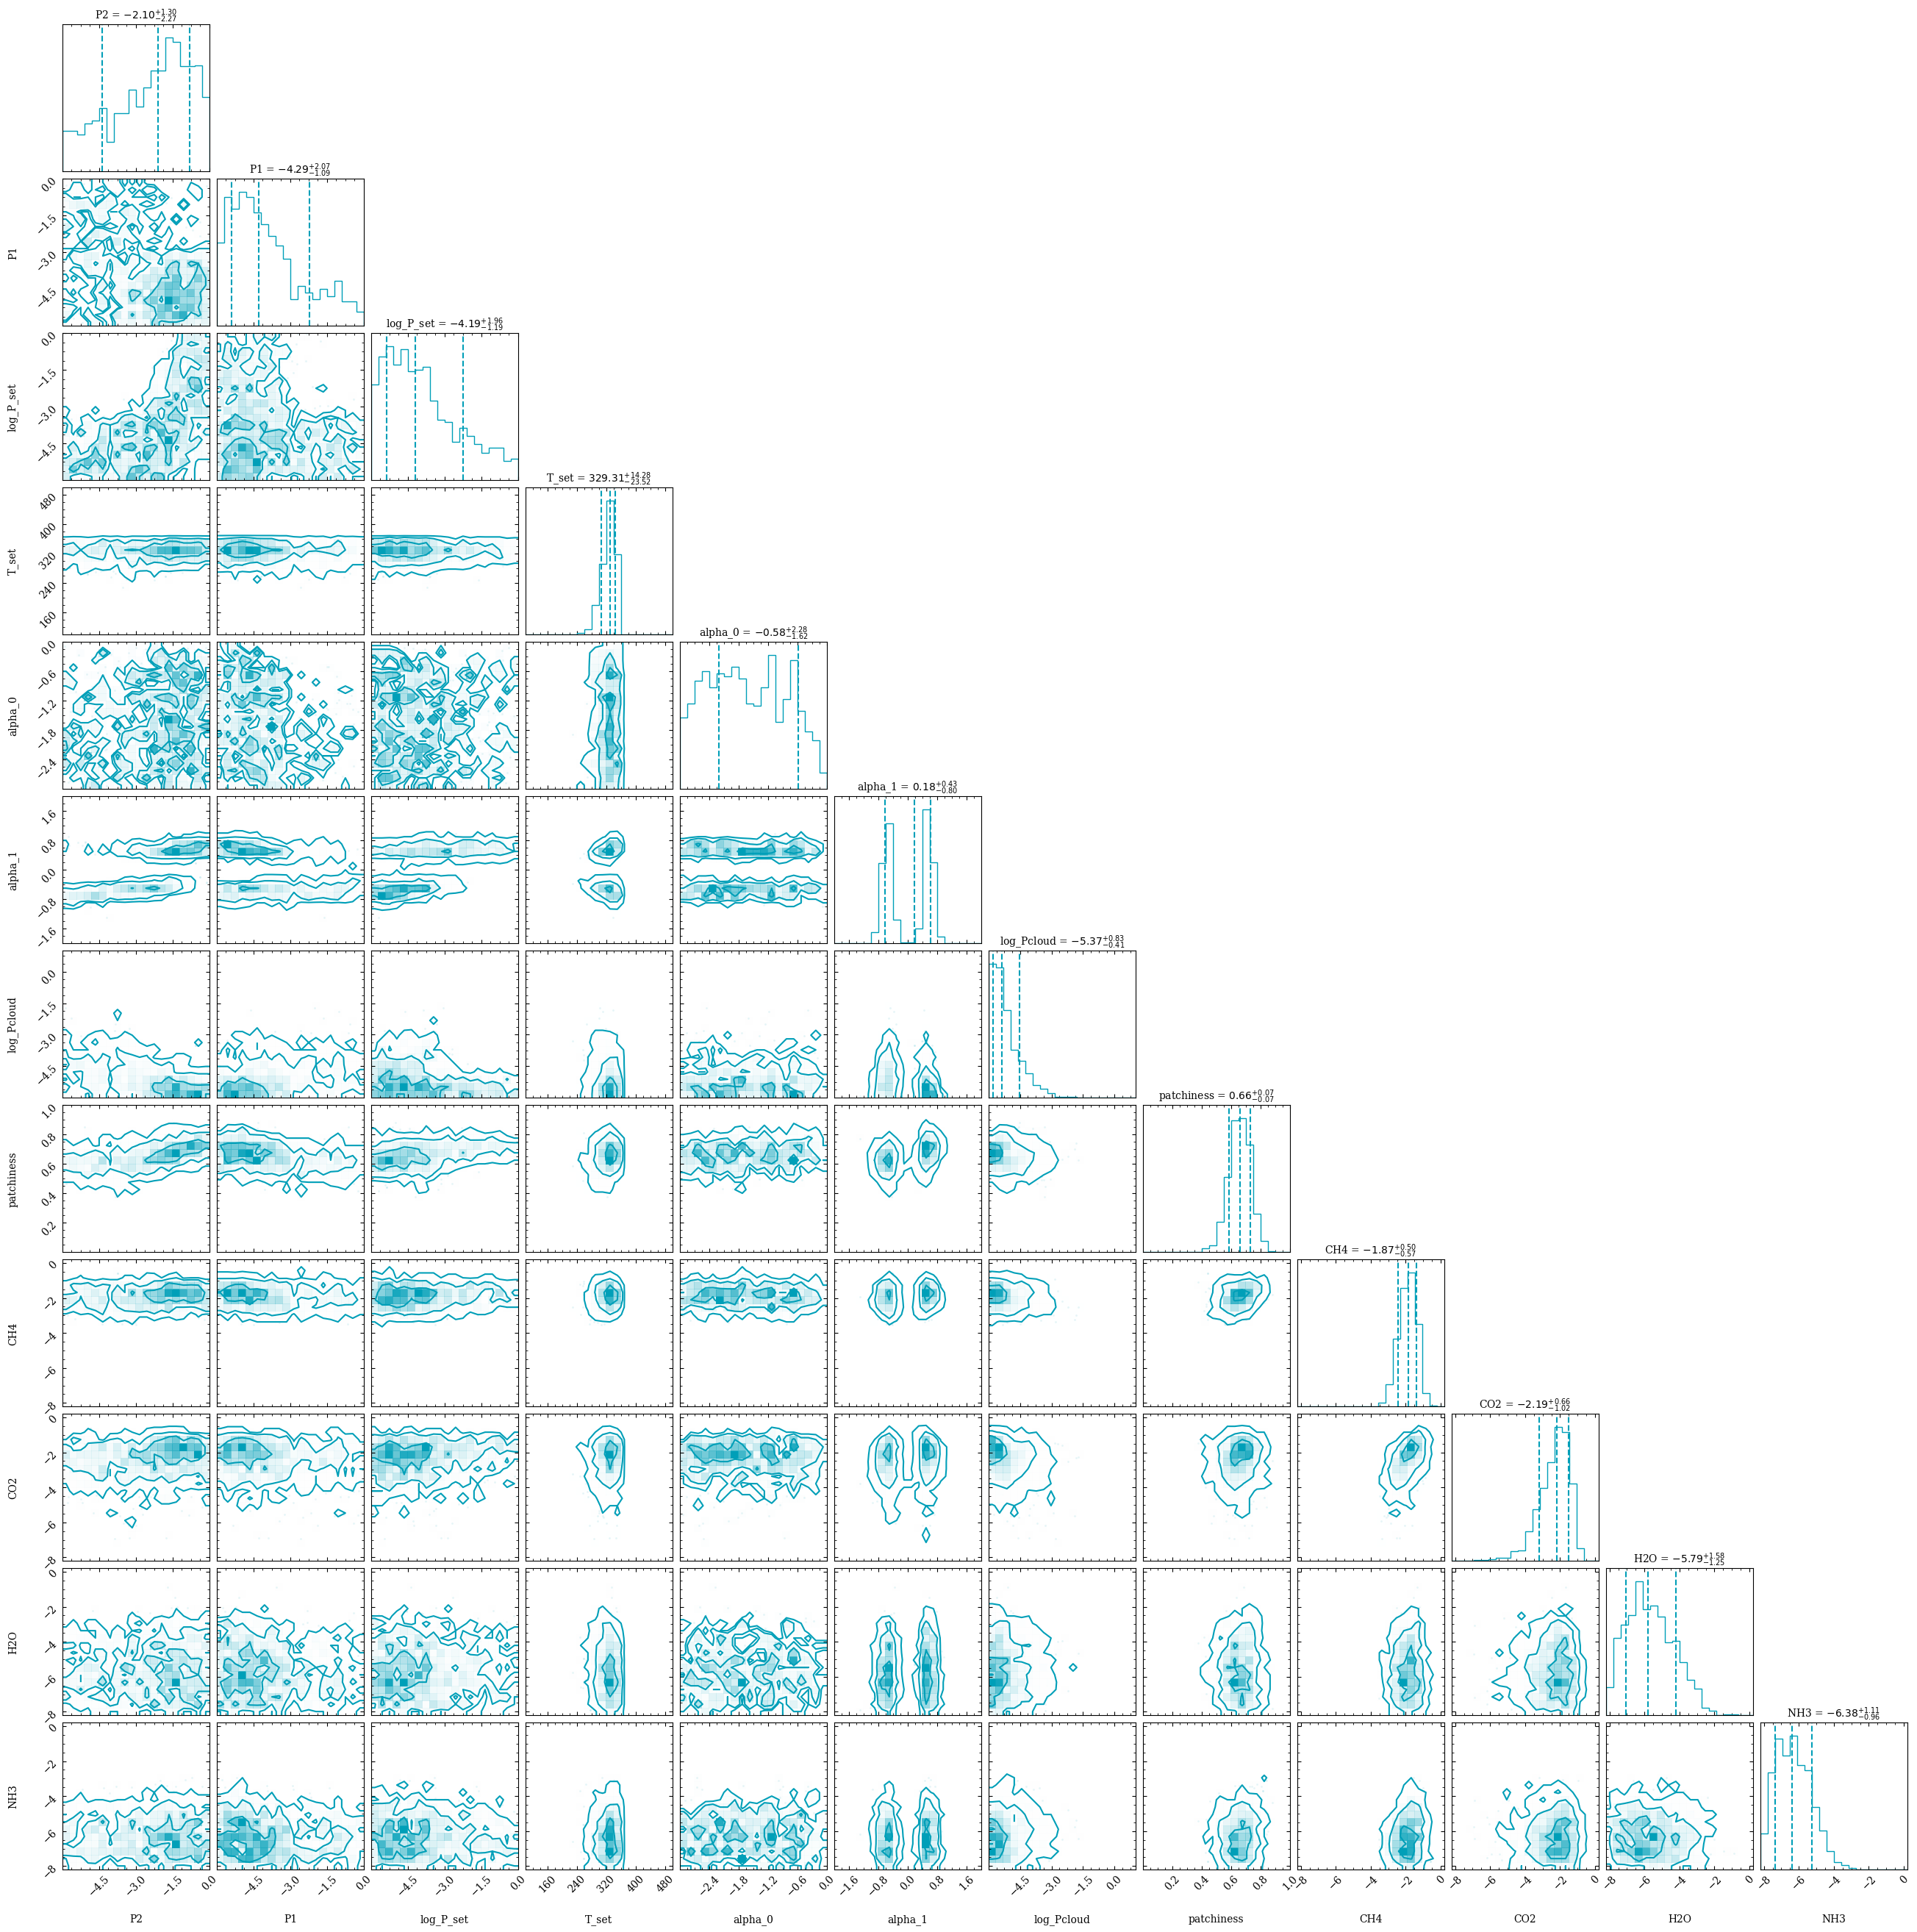

In [5]:
retrieval.plot_corner(sample_dict, parameter_dict, parameters_read, title_kwargs= {"fontsize" : 10})
plt.show()

Caso p_set en layer 2
P_set: 0.013869618310354628, T_set: 302.5052031179479
P_0: 1e-06, T_0: 639.0613231475975
P_1: 4.538144491538581e-06, T_1: 640.8720179840074
P_2: 0.016820440572539036, T_2: 302.31867228092614


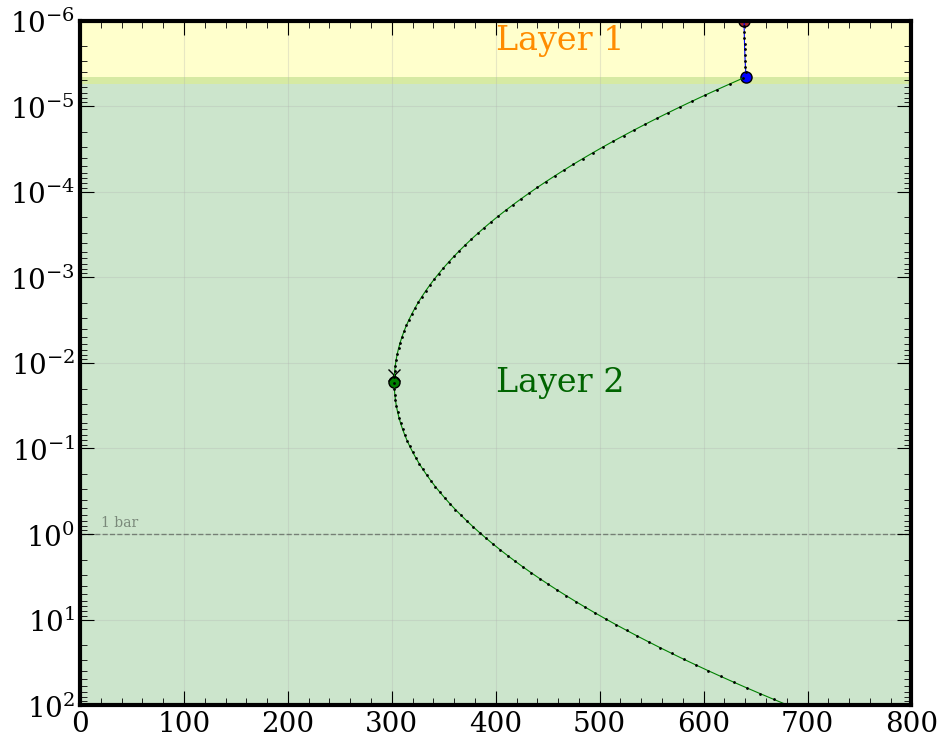

In [10]:
p_0 = retrieval.configuration.pressures[0]
p_1 = retrieval.best_fit_parameters['P1'].value
p_2 = retrieval.best_fit_parameters['P2'].value
p_set = np.exp(retrieval.best_fit_parameters['log_P_set'].value)
t_set = retrieval.best_fit_parameters['T_set'].value
a_0 = retrieval.best_fit_parameters['alpha_0'].value
a_1 = retrieval.best_fit_parameters['alpha_1'].value
b_0 = 0.5
b_1 = 0.5

model = madhu_seager_two_layers(retrieval.configuration.pressures, 
                                   [p_0, p_1, p_2],
                                   [p_set, t_set],
                                   [a_0, a_1],
                                   [b_0, b_1])


ax = plt.figure(figsize=(10,8)).gca()
ax.plot(model['t_0'], p_0, color='brown', marker='o')
ax.plot(model['t_1'], p_1, color='blue', marker='o')
ax.plot(model['t_2'], p_2, color='green', marker='o')
ax.plot(t_set, p_set, color='black', marker='x')
ax.plot(model["region_2"]["ts"], model["region_2"]["ps"], '.-', color='green', linewidth=0.8, markersize=2)
ax.plot(model["region_1"]["ts"], model["region_1"]["ps"], '.-', color='blue', linewidth=0.8, markersize=2)
ax.text(400, np.sqrt(p_0 * p_1), 'Layer 1', color='darkorange')
ax.text(400, np.sqrt(1e2 * p_1), 'Layer 2', color='darkgreen')
ax.set(yscale='log')
ax.set(ylim=(1e-6, 1e2), xlim=(0, 800))
ax.axhline(y=0.986923, linestyle="--", color="k", linewidth=1, alpha=0.4)
ax.text(20, 0.8, "1 bar", fontsize=10, alpha=0.4) 
ax.invert_yaxis()
ax.add_patch(Rectangle((0, p_1), 1500, 200, facecolor='green', alpha=0.2))
ax.add_patch(Rectangle((p_1, 1e-6), 1500, p_1, facecolor='yellow', alpha=0.2))
ax.grid(alpha=0.3)
print(f'P_set: {p_set}, T_set:', model['t_set'])
print(f'P_0: {p_0}, T_0:', model['t_0'])
print(f'P_1: {p_1}, T_1:', model['t_1'])
print(f'P_2: {p_2}, T_2:', model['t_2'])
plt.show()

In [7]:
parameters = {
    'stellar_radius': Parameter('stellar_radius', False, value= planet.star_radius),
    'planet_radius': Parameter('planet_radius', False, value= 0.211*cst.r_jup),
    'mass': Parameter('mass', False, value= 0.02807*cst.m_jup),
    'P1': Parameter('P1', False, value= retrieval.best_fit_parameters['P1'].value),
    'P2': Parameter('P2', False, value= retrieval.best_fit_parameters['P2'].value),
    'log_P_set': Parameter('log_P_set', False, value= retrieval.best_fit_parameters['log_P_set'].value),
    'T_set': Parameter('T_set', False, value= retrieval.best_fit_parameters['T_set'].value),
    'alpha_0': Parameter('alpha_0', False, value= retrieval.best_fit_parameters['alpha_0'].value),
    'alpha_1': Parameter('alpha_1', False, value= retrieval.best_fit_parameters['alpha_1'].value),
    'log_Pcloud': Parameter('log_Pcloud', False, value= retrieval.best_fit_parameters['log_Pcloud'].value),
    'patchiness': Parameter('patchiness', False, value= retrieval.best_fit_parameters['patchiness'].value),
    'CH4': Parameter('CH4', False, value= retrieval.best_fit_parameters['CH4'].value),
    'CO2': Parameter('CO2', False, value= retrieval.best_fit_parameters['CO2'].value),
    'H2O': Parameter('H2O', False, value= retrieval.best_fit_parameters['H2O'].value),
    'NH3': Parameter('NH3', False, value= retrieval.best_fit_parameters['NH3'].value),
}

line_species = [
    'CH4',
    'CO2',
    'H2O',
    'NH3'
]

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = []
pressures = np.logspace(-6,2,100)
wls = np.concatenate([retrieval_config.data['K2-18b_NIRISS'].wavelengths, retrieval_config.data['K2-18b_NIRSPEC'].wavelengths])

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[wls[0], wls[-1]]
)

wavelength, model = madhushudhan_seager_transmission_modified(atmosphere, parameters, amr = False, pt_plot_mode = False)
pressure,temperature = madhushudhan_seager_transmission_modified(atmosphere, parameters, amr = False, pt_plot_mode = True)

Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-N

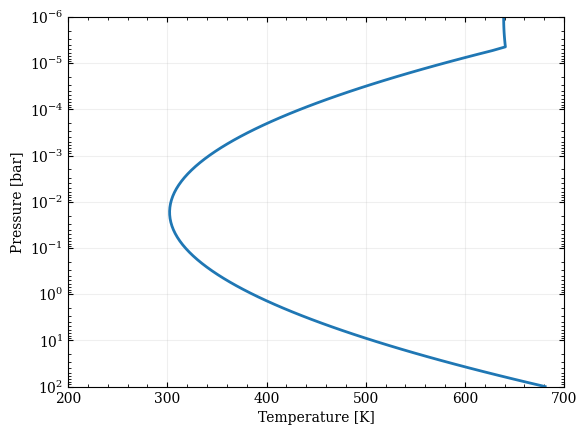

In [8]:
fig, ax = plt.subplots()
ax.plot(temperature, pressure, linewidth = 2)
ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r"Pressure [bar]")
ax.set_ylim(1e2,1e-6)
ax.set_xlim(200, 700)
ax.set_yscale('log')
ax.grid(alpha=0.2)
plt.show()


Plotting Best-fit contribution function
Best fit likelihood = 28832.05
Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/inpu

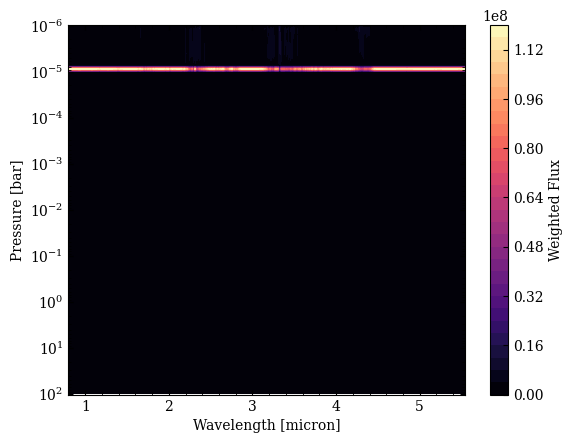

In [11]:
retrieval.plot_contribution(samples_use, parameters_read)
plt.show()

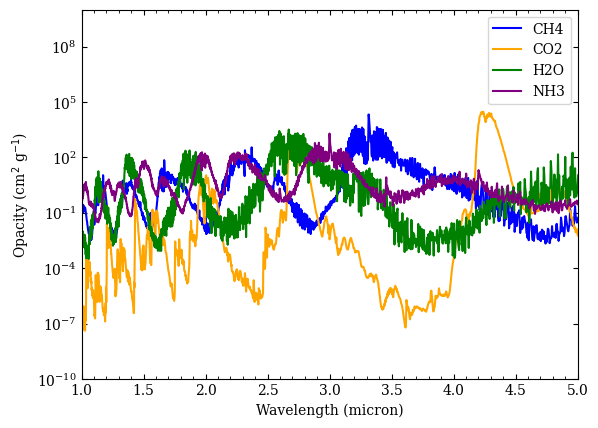

In [12]:
opacities = plot_radtrans_opacities(
    atmosphere,
    atmosphere.line_species,
    temperature=442,
    pressure_bar=1,
    return_opacities=True
)

colors = ['blue', 'orange', 'green', 'purple']
i=0
for species in opacities.keys():
    plt.plot(opacities[species][0], opacities[species][1], label=species,
             color=colors[i]
            )
    i+=1

plt.yscale('log')
plt.xlim([1,5])
plt.ylim([1e-10,1e10])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()
plt.show()

Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-N

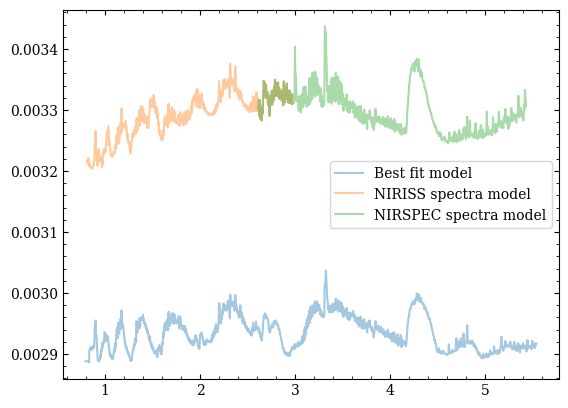

In [13]:
# retrieval.get_reduced_chi2_from_model(wavelength, model, verbose=True, show_chi2=True)

x0, y0 = retrieval.get_best_fit_model(np.array([value for item, value in retrieval.get_best_fit_parameters().items()]), parameters_read)
x1, y1 = retrieval.calculate_forward_model()["K2-18b_NIRISS"]
x2, y2 = retrieval.calculate_forward_model()["K2-18b_NIRSPEC"]
plt.plot(x0, y0, label="Best fit model", alpha=0.4)
plt.plot(x1, y1, label="NIRISS spectra model", alpha=0.4)
plt.plot(x2, y2, label="NIRSPEC spectra model", alpha=0.4)
plt.legend()
plt.show()